# Import 

In [65]:
# Data Processing and Visualization Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


#  Data Modelling Libraries
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                             GradientBoostingClassifier, ExtraTreesClassifier,
                             VotingClassifier)

from sklearn.model_selection import (GridSearchCV, cross_val_score, cross_val_predict,
                                     StratifiedKFold, learning_curve)


from sklearn.metrics import (confusion_matrix, accuracy_score) 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import warnings
from collections import Counter

sns.set(style = 'white' , context = 'notebook', palette = 'deep')
warnings.filterwarnings('ignore', category = DeprecationWarning)
%matplotlib inline

# Get Data Sets

In [66]:
# load the datasets using pandas's read_csv method
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print(type(train))
# concat these two datasets, this will come handy while processing the data
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

# separately store ID of test datasets, 
# this will be using at the end of the task to predict.
TestPassengerID = test['PassengerId']



<class 'pandas.core.frame.DataFrame'>


## Look Inside

In [67]:
# shape of the data set
train.shape

(891, 12)

In [68]:
# first 5 records
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


PassengerId. Unique identification of the passenger. It shouldn't be necessary for the machine learning model.

Survived. Survival (0 = No, 1 = Yes). Binary variable that will be our target variable.

Pclass. Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd). Ready to go.

Name. Name of the passenger. We need to parse before using it.

Sex. Gender Categorical variable that should be encoded. We can use dummy variable to encode it.

Age. Age in years.

SibSp. Siblings / Spouses aboard the Titanic.

Parch. Parents / Children aboard the Titanic.

Ticket. Ticket number. Big mess.

Fare. Passenger fare.

Cabin. Cabin number.

Embarked. Port of Embarkation , C = Cherbourg, Q = Queenstown, S = Southampton.

Categorical feature that should be encoded. We can use feature mapping or make dummy vairables for it.

In [69]:
# using info method we can get quick overview of the data sets
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [70]:
def find_missing_data(data):
    Total = data.isnull().sum().sort_values(ascending = False)
    Percentage = (data.isnull().sum()/data.isnull().count()).sort_values(ascending = False)
    
    return pd.concat([Total, Percentage] , axis = 1 , keys = ['Total' , 'Percent'])

In [71]:
find_missing_data(train)

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000


<AxesSubplot:>

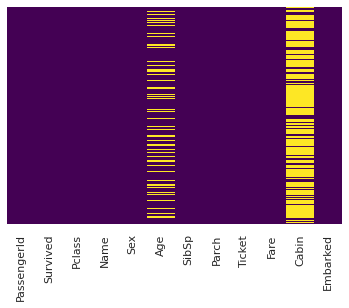

In [72]:
# checking only train set - visualize
sns.heatmap(train.isnull(), cbar = False , 
            yticklabels = False , cmap = 'viridis')

In [73]:
find_missing_data(dataset)

,Total,Percent
Cabin,1014,0.774637
Survived,418,0.319328
Age,263,0.200917
Embarked,2,0.001528
Fare,1,0.000764
PassengerId,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000


<AxesSubplot:>

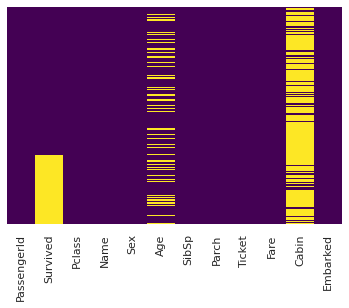

In [74]:
# checking only datasets set
sns.heatmap(dataset.isnull(), cbar = False , 
            yticklabels = False , cmap = 'viridis')

# Feature Analysis 

In [75]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | 
                              (df[col] > Q3 + outlier_step )].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
   
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)  

    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [76]:
# Show the outliers rows
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [77]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

# after removing outlier, let's re-concat the data sets
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

# Numerical Analysis

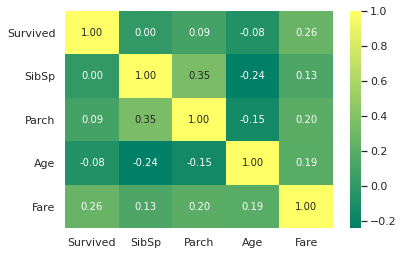

In [78]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
corr_numeric = sns.heatmap(dataset[["Survived","SibSp","Parch","Age","Fare"]].corr(),
                           annot=True, fmt = ".2f", cmap = "summer")

## Age

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


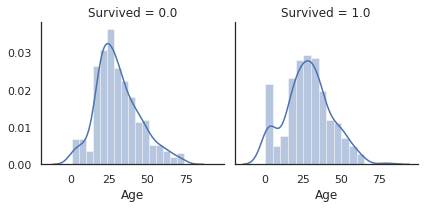

In [80]:
# Explore the Age vs Survived features
age_survived = sns.FacetGrid(dataset, col='Survived')
age_survived = age_survived.map(sns.distplot, "Age")

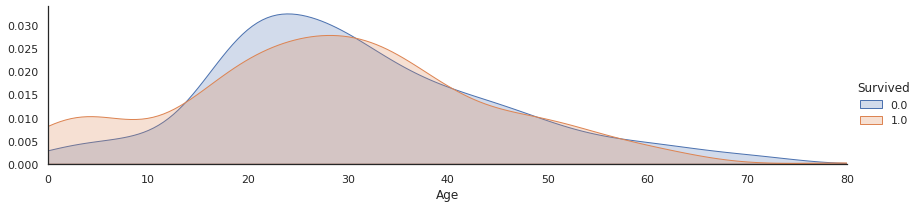

In [81]:
fig = sns.FacetGrid(dataset, hue = 'Survived', aspect = 4)
fig.map(sns.kdeplot, 'Age' , shade = True)
fig.set(xlim = (0, dataset['Age'].max()))
fig.add_legend()

## Missing Age Value

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


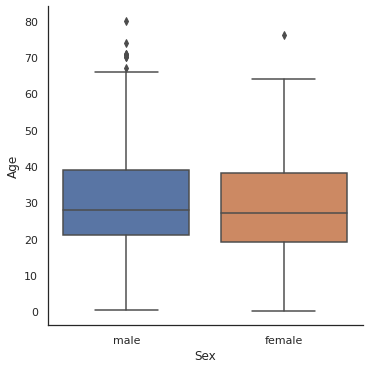

In [82]:
# visualize this using box plot
AS = sns.factorplot(y="Age", x="Sex", data = dataset, kind="box")

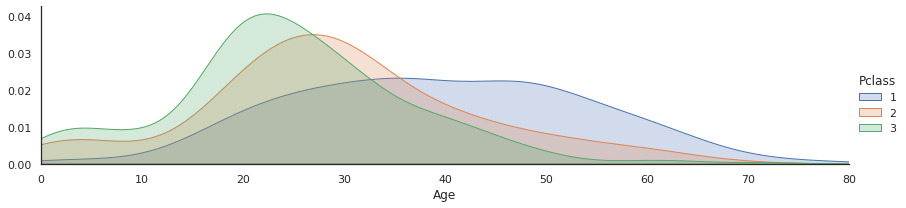

In [83]:
facet = sns.FacetGrid(dataset, hue="Pclass", aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.show()

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


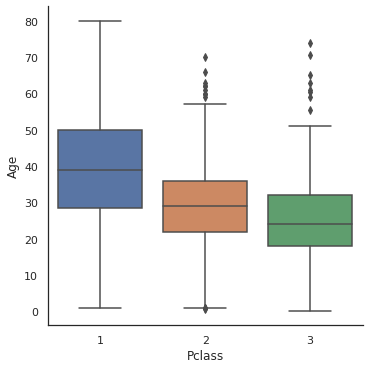

In [84]:
# using boxplot 
PA = sns.factorplot(data = dataset , x = 'Pclass' , y = 'Age', kind = 'box')

In [85]:
# a custom function for age imputation
def AgeImpute(df):
    Age = df[0]
    Pclass = df[1]
    
    if pd.isnull(Age):
        if Pclass == 1: return 37
        elif Pclass == 2: return 29
        else: return 24
    else:
        return Age

# Age Impute
dataset['Age'] = dataset[['Age' , 'Pclass']].apply(AgeImpute, axis = 1)

<AxesSubplot:>

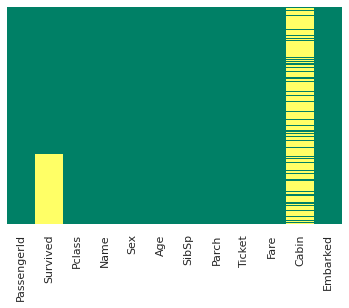

In [86]:
# age featured imputed; no missing age records
sns.heatmap(dataset.isnull(), yticklabels = False, cbar = False, cmap = 'summer')

## SibSP

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


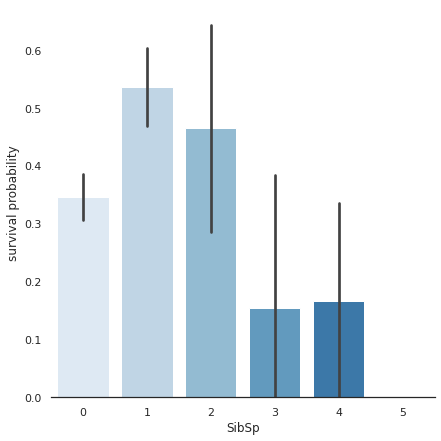

In [87]:
# Explore SibSp feature vs Survived
# We'll use factorplot to analysis
Sib_Sur = sns.factorplot(x="SibSp",y="Survived",data=train,
                   kind="bar", size = 6 , palette = "Blues")

Sib_Sur.despine(left=True)
Sib_Sur = Sib_Sur.set_ylabels("survival probability")

## Parch

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


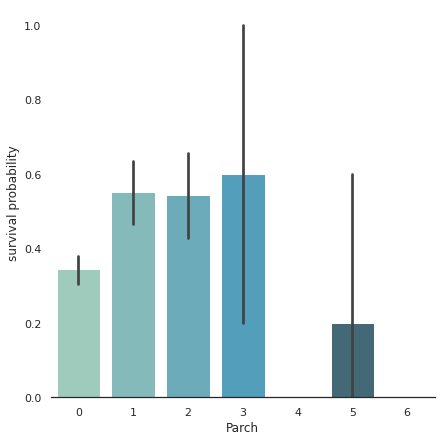

In [88]:
# Explore Parch feature vs Survived
# We'll use factorplot to analysis
Sur_Par = sns.factorplot(x="Parch",y="Survived",data=train, 
                         kind="bar", size = 6 , palette = "GnBu_d")

Sur_Par.despine(left=True)
Sur_Par = Sur_Par.set_ylabels("survival probability")


## Fare

In [89]:
dataset["Fare"].isnull().sum()

1

In [90]:
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

## Categorical values

### sex

In [91]:
print(dataset['Sex'].head()) # top 5
print(' ')
print(dataset['Sex'].tail()) # last 5

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object
 
1294      male
1295    female
1296      male
1297      male
1298      male
Name: Sex, dtype: object


In [92]:
# convert Sex into categorical value 0 for male and 1 for female
sex = pd.get_dummies(dataset['Sex'], drop_first = True)
dataset = pd.concat([dataset,sex], axis = 1)

# After now, we really don't need to Sex features, we can drop it.
dataset.drop(['Sex'] , axis = 1 , inplace = True)

<AxesSubplot:xlabel='Survived', ylabel='count'>

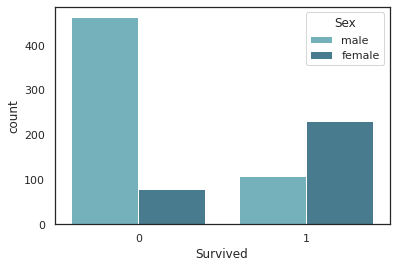

In [93]:
# using countplot to estimate amount
sns.countplot(data = train , x = 'Survived' , hue = 'Sex', palette = 'GnBu_d')

In [94]:
# let's see the percentage
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


## Pclass

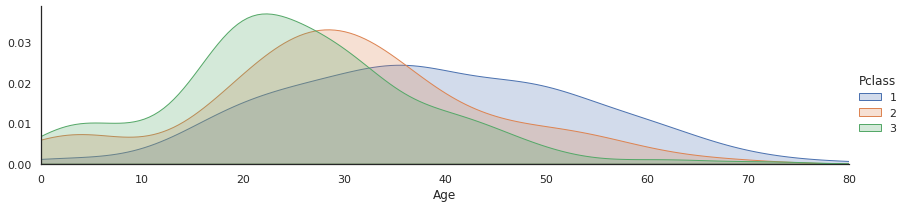

In [95]:
facet = sns.FacetGrid(train, hue="Pclass",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.show()

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


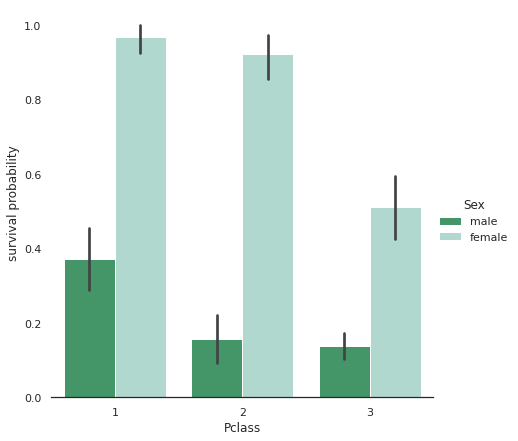

In [96]:
Survived_Pcalss = sns.factorplot(x="Pclass", y="Survived", 
                                 hue="Sex", data=train,size=6, 
                                 kind="bar", palette="BuGn_r")
Survived_Pcalss.despine(left=True)
Survived_Pcalss = Survived_Pcalss.set_ylabels("survival probability")

## Embarked

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


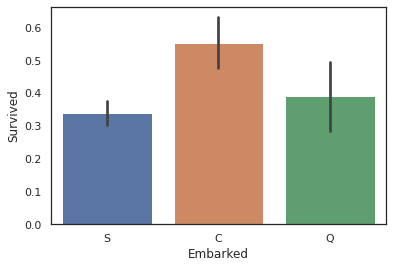

In [97]:
# 'Embarked' vs 'Survived'
sns.barplot(dataset['Embarked'], dataset['Survived']);

In [98]:
# Count
print(dataset.groupby(['Embarked'])['PassengerId'].count())

# Compare with other variables
dataset.groupby(['Embarked']).mean()

Embarked
C    270
Q    123
S    904
Name: PassengerId, dtype: int64


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male
Embarked,,,,,,,,
C,690.655556,0.553571,1.851852,31.242296,0.400000,0.370370,62.336267,0.581481
Q,668.593496,0.389610,2.894309,25.963415,0.341463,0.113821,12.409012,0.512195
S,645.971239,0.339117,2.347345,28.973175,0.484513,0.409292,26.296450,0.683628


In [99]:
# count missing values
print(dataset["Embarked"].isnull().sum())

# Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

2


<AxesSubplot:>

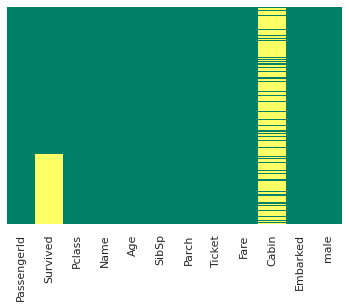

In [100]:
# let's visualize it to confirm
sns.heatmap(dataset.isnull(), yticklabels = False, 
            cbar = False, cmap = 'summer')

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


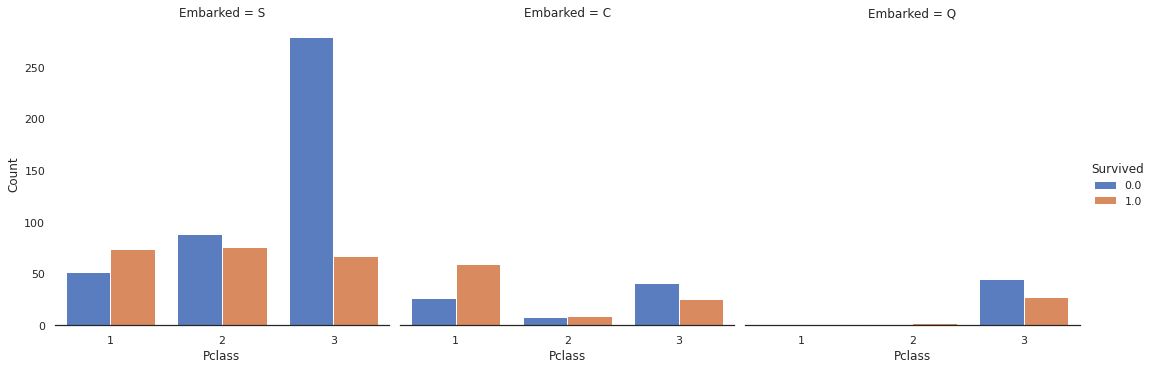

In [101]:
# Counting passenger based on Pclass and Embarked 
Embarked_Pc = sns.factorplot("Pclass", col="Embarked",  data=dataset,
                   size=5, kind="count", palette="muted", hue = 'Survived')

Embarked_Pc.despine(left=True)
Embarked_Pc = Embarked_Pc.set_ylabels("Count")

In [102]:
# create dummy variable
embarked = pd.get_dummies(dataset['Embarked'], drop_first = True)
dataset = pd.concat([dataset,embarked], axis = 1)

# after now, we don't need Embarked coloumn anymore, so we can drop it.
dataset.drop(['Embarked'] , axis = 1 , inplace = True)

# Commitment for Feature Analysis

In [103]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,male,Q,S
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,1,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,0,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0,0,1
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,1,0,1


# Feature Engineering

## Name

In [104]:
dataset['Name'].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [105]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]

# add dataset_title to the main dataset named 'Title'
dataset["Title"] = pd.Series(dataset_title)

# count
dataset["Title"].value_counts()

Mr              753
Miss            255
Mrs             197
Master           60
Dr                8
Rev               8
Col               4
Ms                2
Major             2
Mlle              2
Capt              1
Jonkheer          1
Lady              1
the Countess      1
Don               1
Sir               1
Mme               1
Dona              1
Name: Title, dtype: int64

<AxesSubplot:xlabel='Title', ylabel='Age'>

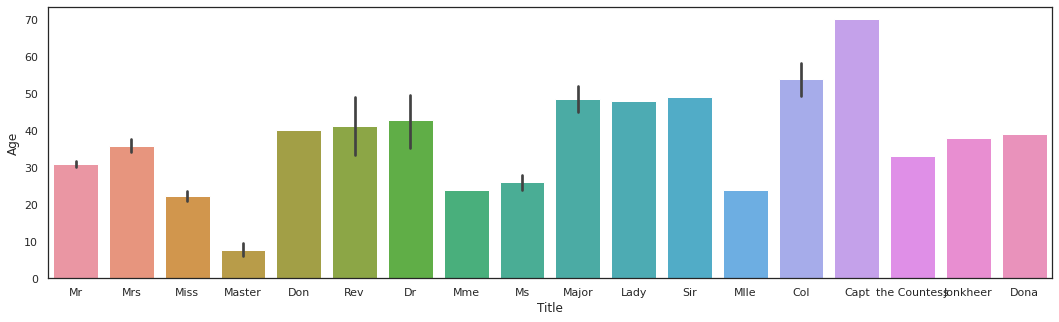

In [106]:
# Plot bar plot (titles and Age)
plt.figure(figsize=(18,5))
sns.barplot(x=dataset['Title'], y = dataset['Age'])

In [107]:
# Means per title
print(dataset.groupby('Title')['Age'].mean())

Title
Capt            70.000000
Col             54.000000
Don             40.000000
Dona            39.000000
Dr              42.750000
Jonkheer        38.000000
Lady            48.000000
Major           48.500000
Master           7.643000
Miss            22.261137
Mlle            24.000000
Mme             24.000000
Mr              30.926295
Mrs             35.898477
Ms              26.000000
Rev             41.250000
Sir             49.000000
the Countess    33.000000
Name: Age, dtype: float64


In [108]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess',
                                             'Capt', 'Col','Don', 'Dr', 
                                             'Major', 'Rev', 'Sir', 'Jonkheer',
                                             'Dona'], 'Rare')

dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 ,
                                         "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, 
                                         "Rare":3})

dataset["Title"] = dataset["Title"].astype(int)

# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


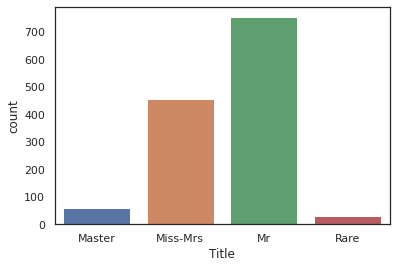

In [109]:
# viz counts the title coloumn
sns.countplot(dataset["Title"]).set_xticklabels(["Master","Miss-Mrs","Mr","Rare"]);

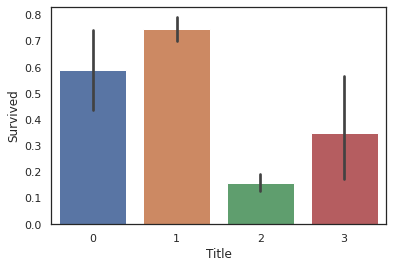

In [110]:
# Let's see, based on title what's the survival probability
sns.barplot(x='Title', y='Survived', data=dataset);

In [111]:

# viz top 5
dataset.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,male,Q,S,Title
0,1,0.0,3,22.0,1,0,A/5 21171,7.2500,NaN,1,0,1,2
1,2,1.0,1,38.0,1,0,PC 17599,71.2833,C85,0,0,0,1
2,3,1.0,3,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,1
3,4,1.0,1,35.0,1,0,113803,53.1000,C123,0,0,1,1
4,5,0.0,3,35.0,0,0,373450,8.0500,NaN,1,0,1,2


## Family size

In [112]:
# Create a family size descriptor from SibSp and Parch
dataset["Famize"] = dataset["SibSp"] + dataset["Parch"] + 1

# Drop SibSp and Parch variables
dataset.drop(labels = ["SibSp",'Parch'], axis = 1, inplace = True)

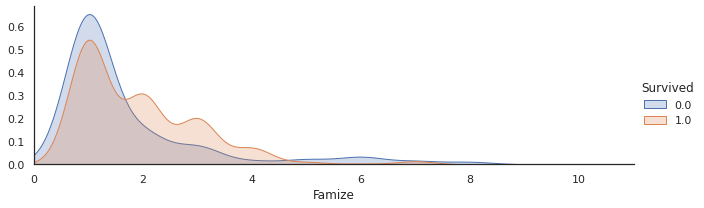

In [113]:
# Viz the survival probabily of Famize feature

facet = sns.FacetGrid(dataset, hue="Survived",aspect=3)
facet.map(sns.kdeplot,'Famize',shade= True)
facet.set(xlim=(0, dataset['Famize'].max()))
facet.add_legend()
plt.xlim(0);

## Cabin & Ticke

In [114]:
# drop some useless features
dataset.drop(labels = ["Ticket",'Cabin','PassengerId'], axis = 1, 
             inplace = True)

# Predictive Modeling

In [115]:
# Separate train dataset and test dataset
train = dataset[:len(train)]
test = dataset[len(train):]
test.drop(labels=["Survived"],axis = 1,inplace = True)

## Separate train features and label 
Y_train = train["Survived"].astype(int)
X_train = train.drop(labels = ["Survived"],axis = 1)

# Cross validate model with Kfold stratified cross val
K_fold = StratifiedKFold(n_splits=10)
type(dataset)

/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


pandas.core.frame.DataFrame

## Classifier

## Evaluation using Cross Validation

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

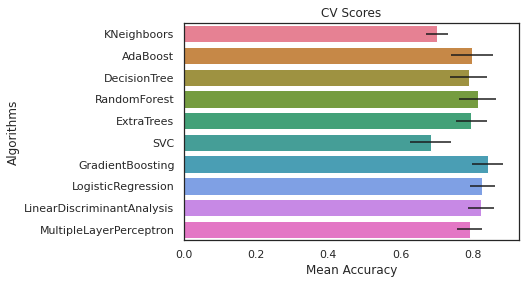

In [116]:
# Modeling step Test differents algorithms 
random_state = 2

models = [] # добавить все модели или прогнозные модели
cv_results = [] # результат перекрестной проверки
cv_means = [] # среднее значение перекрестной проверки
cv_std = [] # стандартное отклонение перекрестной проверки

models.append(KNeighborsClassifier())
models.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
models.append(DecisionTreeClassifier(random_state=random_state))
models.append(RandomForestClassifier(random_state=random_state))
models.append(ExtraTreesClassifier(random_state=random_state))
models.append(SVC(random_state=random_state))
models.append(GradientBoostingClassifier(random_state=random_state))
models.append(LogisticRegression(random_state = random_state))
models.append(LinearDiscriminantAnalysis())
models.append(MLPClassifier(random_state=random_state))


for model in models :
    cv_results.append(cross_val_score(model, X_train, Y_train, 
                                      scoring = "accuracy", cv = K_fold, n_jobs=4))

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_frame = pd.DataFrame(
    {
        "CrossValMeans":cv_means,
        "CrossValErrors": cv_std,
        "Algorithms":[
                     "KNeighboors",
                     "AdaBoost", 
                     "DecisionTree",   
                     "RandomForest",
                     "ExtraTrees",
                     "SVC",
                     "GradientBoosting",                      
                     "LogisticRegression",
                     "LinearDiscriminantAnalysis",
                     "MultipleLayerPerceptron"]
    })

cv_plot = sns.barplot("CrossValMeans","Algorithms", data = cv_frame,
                palette="husl", orient = "h", **{'xerr':cv_std})

cv_plot.set_xlabel("Mean Accuracy")
cv_plot = cv_plot.set_title("CV Scores")

In [117]:
# GBC Classifier
GBC_Model = GradientBoostingClassifier()

scores = cross_val_score(GBC_Model, X_train, Y_train, cv = K_fold,
                       n_jobs = 4, scoring = 'accuracy')

print(scores)
round(np.mean(scores)*100, 2)

[0.83146067 0.82954545 0.76136364 0.89772727 0.90909091 0.875
 0.84090909 0.79545455 0.84090909 0.82954545]


84.11

In [118]:
# Linear Discriminant Analysis 
LDA_Model= LinearDiscriminantAnalysis()

scores = cross_val_score(LDA_Model, X_train, Y_train, cv = K_fold,
                       n_jobs = 4, scoring = 'accuracy')

print(scores)
round(np.mean(scores)*100, 2)

[0.84269663 0.82954545 0.76136364 0.88636364 0.81818182 0.80681818
 0.79545455 0.78409091 0.86363636 0.84090909]


82.29

In [119]:
# Logistic Regression
#
Log_Model = LogisticRegression(C=1)
scores = cross_val_score(Log_Model, X_train, Y_train, cv=K_fold, 
                        n_jobs=4, scoring='accuracy')

print(scores)
round(np.mean(scores)*100, 2)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[0.80898876 0.85227273 0.77272727 0.88636364 0.82954545 0.79545455
 0.79545455 0.80681818 0.85227273 0.86363636]


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

82.64

In [61]:
# Random Forest Classifier Model
#
RFC_model = RandomForestClassifier(n_estimators=10)
scores = cross_val_score(RFC_model, X_train, Y_train, cv=K_fold, 
                        n_jobs=4, scoring='accuracy')

print(scores)
round(np.mean(scores)*100, 2)

[0.7752809  0.86363636 0.75       0.81818182 0.86363636 0.78409091
 0.80681818 0.73863636 0.80681818 0.80681818]


80.14

In [62]:
# Gaussian Naive Bayes
GNB_Model = GaussianNB()

scores = cross_val_score(GNB_Model, X_train, Y_train, cv=K_fold, 
                        n_jobs=4, scoring='accuracy')

print(scores)
round(np.mean(scores)*100, 2)

[0.78651685 0.81818182 0.75       0.86363636 0.77272727 0.79545455
 0.80681818 0.78409091 0.85227273 0.84090909]


80.71

In [63]:
# Support Vector Machine
SVM_Model = SVC()

scores = cross_val_score(SVM_Model, X_train, Y_train, cv=K_fold, 
                        n_jobs=4, scoring='accuracy')

print(scores)
round(np.mean(scores)*100, 2)

[0.59550562 0.56818182 0.70454545 0.75       0.65909091 0.69318182
 0.70454545 0.73863636 0.71590909 0.70454545]


68.34

# Hyperparameter Tuning

In [64]:
# Gradient boosting tunning
GBC = GradientBoostingClassifier()
gb_param_grid = {
              'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01, 0.001],
              'max_depth': [4, 8,16],
              'min_samples_leaf': [100,150,250],
              'max_features': [0.3, 0.1]
              }

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv=K_fold, 
                     scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)
GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


KeyboardInterrupt: 

In [ ]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "min_samples_split": [2, 6, 20],
              "min_samples_leaf": [1, 4, 16],
              "n_estimators" :[100,200,300,400]}


gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv=K_fold,
                     scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)
RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

In [ ]:
# LogisticRegression Parameters tunning 
LRM = LogisticRegression()

## Search grid for optimal parameters
lr_param_grid = {"penalty" : ["l2"],
              "tol" : [0.0001,0.0002,0.0003],
              "max_iter": [100,200,300],
              "C" :[0.01, 0.1, 1, 10, 100],
              "intercept_scaling": [1, 2, 3, 4],
              "solver":['liblinear'],
              "verbose":[1]}


gsLRM = GridSearchCV(LRM, param_grid = lr_param_grid, cv=K_fold,
                     scoring="accuracy", n_jobs= 4, verbose = 1)

gsLRM.fit(X_train,Y_train)
LRM_best = gsLRM.best_estimator_

# Best score
gsLRM.best_score_

In [ ]:
# Linear Discriminant Analysis - Parameter Tuning
LDA = LinearDiscriminantAnalysis()

## Search grid for optimal parameters
lda_param_grid = {"solver" : ["svd"],
              "tol" : [0.0001,0.0002,0.0003]}


gsLDA = GridSearchCV(LDA, param_grid = lda_param_grid, cv=K_fold,
                     scoring="accuracy", n_jobs= 4, verbose = 1)

gsLDA.fit(X_train,Y_train)
LDA_best = gsLDA.best_estimator_

# Best score
gsLDA.best_score_

In [ ]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100, 200, 300]}

gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv = K_fold,
                      scoring="accuracy", n_jobs= -1, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

## Plot Learning Curves 

### Bias-Variance Trade-Off

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        
    x1 = np.linspace(0, 10, 8, endpoint=True) produces
        8 evenly spaced points in the range 0 to 10
    """
    
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
# Gradient boosting - Learning Curve 
plot_learning_curve(estimator = gsGBC.best_estimator_,title = "GBC learning curve",
                    X = X_train, y = Y_train, cv = K_fold);

In [ ]:
# Random Forest - Learning Curve
plot_learning_curve(estimator = gsRFC.best_estimator_ ,title = "RF learninc curve",
                    X = X_train, y = Y_train, cv = K_fold);

In [ ]:
# Logistic Regression - Learning Curve    gsLRM.best_estimator_
plot_learning_curve(estimator = Log_Model ,title = "Logistic Regression - Learning Curve",
                    X = X_train, y = Y_train, cv = K_fold);

In [ ]:
# Linear Discriminant Analysis - Learning Curve
plot_learning_curve(estimator = gsLDA.best_estimator_ ,title = "Linear Discriminant - Learning Curve",
                    X = X_train, y = Y_train, cv = K_fold);

In [ ]:
# Support Vector Machine - Learning Curve
plot_learning_curve(estimator = gsSVMC.best_estimator_,title = "SVC learning curve",
                    X = X_train, y = Y_train, cv = K_fold);

# Ensemble modeling

In [ ]:
#about 84%
VotingPredictor = VotingClassifier(estimators =
                           [('rfc', RFC_best), 
                            ('gbc', GBC_best)],
                           voting='soft', n_jobs = 4)

# 82.97%
# VotingPredictor = VotingClassifier(estimators =
#                            [ ('rfc', RFC_best), 
#                             ('svc', SVMC_best),
#                             ('gbc', GBC_best),
#                             ('lda', LDA_best),
#                             ('lrm', LRM_best)],
#                            voting='soft', n_jobs = 4)

VotingPredictor = VotingPredictor.fit(X_train, Y_train)

scores = cross_val_score(VotingPredictor, X_train, Y_train, cv = K_fold,
                       n_jobs = 4, scoring = 'accuracy')

print(scores)
print(round(np.mean(scores)*100, 2))

In [ ]:
# Voting Predictor - Learning Curve
plot_learning_curve(estimator = VotingPredictor, title = "VP learning curve",
                    X = X_train, y = Y_train, cv = K_fold);

## Submit Predictor 

In [ ]:
Predictive_Model = pd.DataFrame({
        "PassengerId": TestPassengerID,
        "Survived": VotingPredictor.predict(test)})

Predictive_Model.to_csv('number_4.csv', index=False)

In [ ]:
# Let's look inside
submission = pd.read_csv('number_4.csv')
submission.head()